In [1]:
#The Python API package and another package to visualize maps
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#autheticate the servers
ee.Authenticate()
#Initialize the API
ee.Initialize()


Enter verification code:  4/1AX4XfWjOYeJ1Y9i98-EbPBh9YR3S09XGqMQpLuR5k-j8SXcQOkArUQy16mQ



Successfully saved authorization token.


In [2]:
import geemap
import geemap.chart as chart

# La Soufrière 
Erupción del 09 de abril del 2021. Del satélite VIIRS, en GEE :VNP09GA: VIIRS Surface Reflectance Daily 500m and 1km.

In [4]:
#Region de interes
square = ee.Geometry.Polygon(
        [[[-62.020931347656266, 13.690977100871581],
          [-62.020931347656266, 12.739098791676222],
          [-60.188961132812516, 12.739098791676222],
          [-60.188961132812516, 13.690977100871581]]], None, False);

In [5]:
m = geemap.Map() # Seinicializa el mapa
m.setCenter(-61.2006, 13.3027, 8) # se centra en la región que se desea visualizar

In [6]:
dataset = ee.ImageCollection('NOAA/VIIRS/001/VNP09GA') \
        .filterDate('2021-04-10', '2021-04-11')
s_1 = dataset.map(lambda img:img.expression('bnd1',{'bnd1':img.select('M5')}).rename('DIF1')) # se pueden realizar operaciones entre bandas
s_2 = dataset.map(lambda img:img.expression('bnd1-bnd2',{'bnd1':img.select('I3'),'bnd2':img.select('M2')}).rename('DIF2'))
s_3 = dataset.map(lambda img:img.expression('bnd1',{'bnd1':img.select('M1')}).rename('DIF3'))
s_t=s_1.combine(s_2)
s_t=s_3.combine(s_t)
rgb={
    'bands':['DIF1','DIF2','DIF3'], #se asignan en orden R-G-B
     'min':1000, # el minimo valor tomado, de alli para abajo se toman como igual al minimo
     'max':2000
}
m.addLayer(s_t,rgb,'false_color')


In [7]:
m

Map(center=[13.3027, -61.2006], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

# Histogramas de Intensidad
Geemao tiene un modulo llamado Chart que ayuda a ver esto

In [9]:
source = ee.ImageCollection('NOAA/VIIRS/001/VNP09GA').filterDate('2021-04-10', '2021-04-11').mean() #se puede convertir de ImageCollection a Image con .mean() o tambien .toBands() lo cual haria una sola imagen con nuevas bandas correspondientes a cada imagen: e.g  'image1_band1'
property = 'M1'
my_sample=source.sample(square,5000)
options = {"title": 'Histograma de Intensidad',
          "xlabel": 'Valor de M1',
          "ylabel": 'Pixel count',
          "colors": ['#7D70BA'],
  
          }       
im=chart.feature_histogram(my_sample, property, **options)

De acuerdo al anterior histograma se puede agregar una capa con un filtro , a partir de 2500 es 1 y antes de estos valores se mapea a 0, de manera que es un capa binaria

In [10]:
thres=dataset.select('M1').mean().gte(2500).rename('threshold')
m.addLayer(thres,{'min':0,'max':1,'bands':['threshold']},'threshold')

In [11]:
m


Map(bottom=15603.0, center=[11.79364827638953, -59.380750997422226], controls=(WidgetControl(options=['positio…

## Es mejor sacar los datos y graficar con matplotlib para visualizar varias bandas

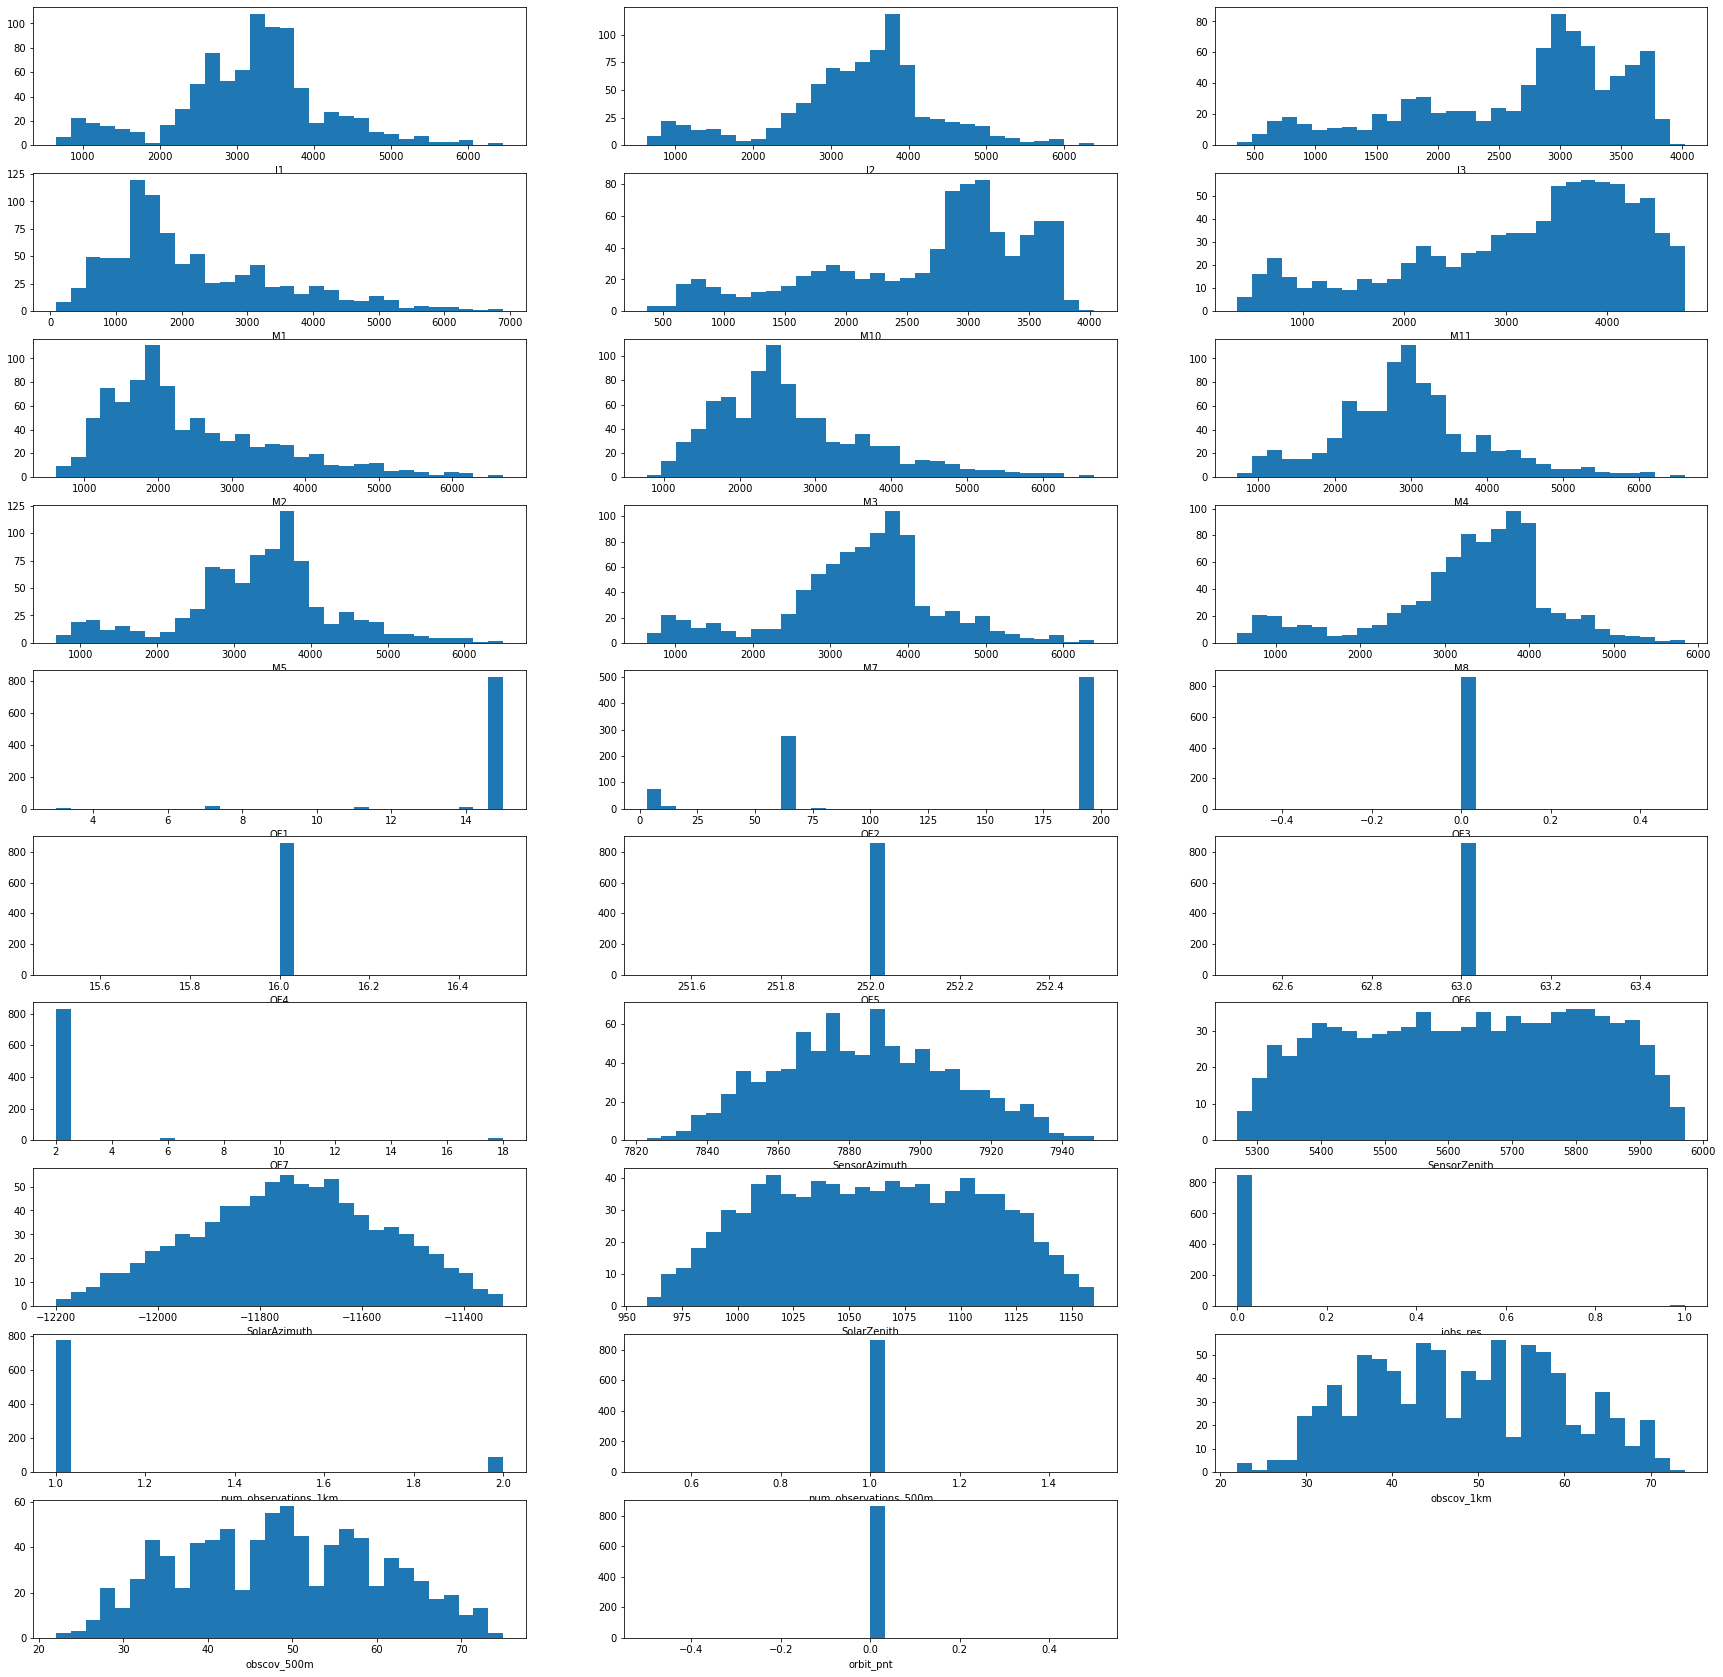

In [33]:
bands=list(my_sample.getInfo()['columns'].keys())
fig = plt.figure(figsize=(30,30))
size=len(bands)
num_bins=30
i=1
for b in bands:
    raw_data= pd.to_numeric(
            pd.Series(my_sample.aggregate_array(b).getInfo())
        )
    data= np.array(raw_data)
    plt.subplot(10,3,i)
    plt.xlabel(b)
    plt.hist(data,num_bins)
    i+=1


In [27]:
size

29